In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


A. Load libraries and data files

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math as math

%matplotlib inline

In [3]:
train_1 = pd.read_csv("/content/drive/MyDrive/web-traffic-time-series-forecasting/train_1.csv/train_1.csv")
keys = pd.read_csv("/content/drive/MyDrive/web-traffic-time-series-forecasting/key_1.csv")
ss = pd.read_csv("/content/drive/MyDrive/web-traffic-time-series-forecasting/sample_submission_1.csv")

In [4]:
print(f'daily web traffic ranging from {train_1.columns.min()} to {train_1.columns.max()}')
print(f'number of rows (websites): {train_1.shape[0]}')
print(f'web traffic missing {round(train_1.isna().values.sum()/train_1.shape[0]/train_1.shape[1]*100, 1)}% of data')

daily web traffic ranging from 2015-07-01 to Page
number of rows (websites): 145063
web traffic missing 7.7% of data


In [ ]:
import re

def breakdown_topic(str):
    m = re.search('(.*)\_(.*).wikipedia.org\_(.*)\_(.*)', str)
    if m is not None:
        return m.group(1), m.group(2), m.group(3), m.group(4)
    else:
        return "", "", "", ""

print(breakdown_topic("Рудова,_Наталья_Александровна_ru.wikipedia.org_all-access_spider"))
print(breakdown_topic("台灣災難列表_zh.wikipedia.org_all-access_spider"))
print(breakdown_topic("File:Memphis_Blues_Tour_2010.jpg_commons.wikimedia.org_mobile-web_all-agents"))

('Рудова,_Наталья_Александровна', 'ru', 'all-access', 'spider')
('台灣災難列表', 'zh', 'all-access', 'spider')
('', '', '', '')


In [ ]:
page_details = train.Page.str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.org\_(?P<access>.*)\_(?P<type>.*)')

page_details[0:10]

,topic,lang,access,type
0,2NE1,zh,all-access,spider
1,2PM,zh,all-access,spider
2,3C,zh,all-access,spider
3,4minute,zh,all-access,spider
4,52_Hz_I_Love_You,zh,all-access,spider
5,5566,zh,all-access,spider
6,91Days,zh,all-access,spider
7,A'N'D,zh,all-access,spider
8,AKB48,zh,all-access,spider
9,ASCII,zh,all-access,spider


In [ ]:
unique_topic = page_details["topic"].unique()
print(unique_topic)
print("Number of distinct topics: ", unique_topic.shape[0])

['2NE1' '2PM' '3C' ... 'Eine_Reihe_betrüblicher_Ereignisse_(Fernsehserie)'
 'ジャック・リーチャー' 'マイク眞木']
Number of distinct topics:  42213


B. Split data into train and validation sets

In [ ]:
train_df = pd.concat([page_details, train], axis=1)

def get_train_validate_set(train_df, test_percent):
    train_end = math.floor((train_df.shape[1]-5) * (1-test_percent))
    train_ds = train_df.iloc[:, np.r_[0,1,2,3,4,5:train_end]]
    test_ds = train_df.iloc[:, np.r_[0,1,2,3,4,train_end:train_df.shape[1]]]
    
    return train_ds, test_ds

X_train, y_train = get_train_validate_set(train_df, 0.1)

print("The training set sample:")
print(X_train[0:10])
print("The validation set sample:")
print(y_train[0:10])

The training set sample:
              topic lang      access  ... 2016-10-30 2016-10-31  2016-11-01
0              2NE1   zh  all-access  ...       50.0       16.0        30.0
1               2PM   zh  all-access  ...       15.0       24.0        13.0
2                3C   zh  all-access  ...        2.0        6.0         1.0
3           4minute   zh  all-access  ...      103.0       22.0        15.0
4  52_Hz_I_Love_You   zh  all-access  ...       18.0       20.0        11.0
5              5566   zh  all-access  ...      102.0       23.0        26.0
6            91Days   zh  all-access  ...       42.0       17.0         7.0
7             A'N'D   zh  all-access  ...       54.0       41.0        77.0
8             AKB48   zh  all-access  ...       43.0       42.0        19.0
9             ASCII   zh  all-access  ...       21.0       27.0        23.0

[10 rows x 495 columns]
The validation set sample:
              topic lang      access  ... 2016-12-29 2016-12-30  2016-12-31
0          

In [ ]:
def extract_series(df, row_num, start_idx):
    y = df.iloc[row_num, start_idx:]
    df = pd.DataFrame({ 'ds': y.index, 'y': y.values})
    return df

In [ ]:
df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)


In [ ]:
df_train

,ds,y
0,2015-07-01,1
1,2015-07-02,0
2,2015-07-03,1
3,2015-07-04,1
4,2015-07-05,0
...,...,...
485,2016-10-28,3
486,2016-10-29,2
487,2016-10-30,2
488,2016-10-31,6


3. ARIMA Model

In [ ]:
def smape(predict, actual, debug=False):
    '''
    predict and actual is a panda series.
    In this implementation I will skip all the datapoint with actual is null
    '''
    actual = actual.fillna(0)
    data = pd.concat([predict, actual], axis=1, keys=['predict', 'actual'])
    data = data[data.actual.notnull()]
    if debug:
        print('debug', data)
    
    evals = abs(data.predict - data.actual) * 1.0 / (abs(data.predict) + abs(data.actual)) * 2
    evals[evals.isnull()] = 0
    #print(np.sum(evals), len(data), np.sum(evals) * 1.0 / len(data))
    
    result = np.sum(evals) / len(data) * 100.0
    
    return result


In [ ]:
def plot_prediction_and_actual_2(train, forecast, actual, xlim=None, ylim=None, figSize=None, title=None):
    fig, ax  = plt.subplots(1,1,figsize=figSize)
    ax.plot(pd.to_datetime(train.index), train.values, 'k.')
    ax.plot(pd.to_datetime(actual.index), actual.values, 'r.')
    ax.plot(pd.to_datetime(forecast.index), forecast.values, 'b-')
    ax.set_title(title)
    plt.show()


In [ ]:
from statsmodels.tsa.arima_model import ARIMA   
import warnings

def arima_model(df_train, df_actual, p, d, q, figSize=(12, 4), review=False):
    df_train = df_train.fillna(0)
    train_series = df_train.y
    train_series.index = df_train.ds

    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(train_series ,[p, d, q])
            result = arima.fit(disp=False)
        except Exception as e:
            print('\tARIMA failed', e)
                
    start_idx = df_train.ds[d]
    end_idx = df_actual.ds.max()
    forecast_series = result.predict(start_idx, end_idx, typ='levels')
    
    actual_series = df_actual.y
    actual_series.index = pd.to_datetime(df_actual.ds)

    if(review):
        plot_prediction_and_actual_2(train_series, forecast_series, actual_series, figSize=figSize, title='ARIMA model')
    return smape(forecast_series, actual_series)

In [ ]:
df_train = df_train.fillna(0)
train_series = df_train.y
train_series.index = df_train.ds

result = None
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    try:
        arima = ARIMA(train_series ,[4, 1, 4])
        result = arima.fit(disp=False)
    except Exception as e:
        print('\tARIMA failed', e)


In [ ]:
print("AR params:", result.arparams, "MA params:", result.maparams)

AR params: [-0.32990652 -0.47159384  0.4637093   0.04614391] MA params: [ 0.20793287 -0.0061323  -0.86194216 -0.33985812]


In [ ]:
start_idx = df_train.ds[1]
end_idx = df_actual.ds.max()
forecast_series = result.predict(start_idx, end_idx, typ='levels')


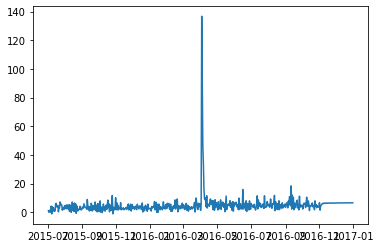

In [ ]:
plt.plot(forecast_series.index, forecast_series.values)
plt.show()

In [ ]:
forecast_series

2015-07-02    1.005647
2015-07-03   -0.027591
2015-07-04    1.335613
2015-07-05    0.815838
2015-07-06    0.040123
                ...   
2016-12-27    6.609849
2016-12-28    6.594392
2016-12-29    6.618062
2016-12-30    6.628264
2016-12-31    6.614064
Freq: D, Length: 549, dtype: float64

                                    Page  2015-07-01  ...  2016-12-30  2016-12-31
2  3C_zh.wikipedia.org_all-access_spider         1.0  ...         4.0        17.0

[1 rows x 551 columns]


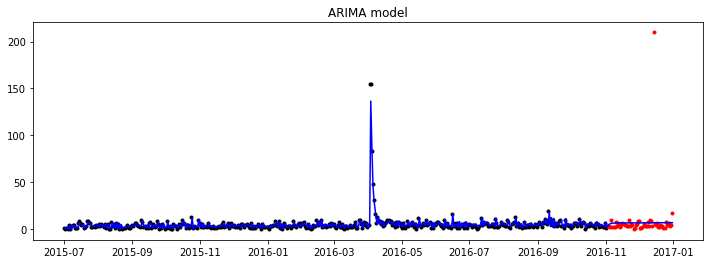

The SMAPE score is : 65.75750


In [ ]:
print(train.iloc[[2]])

df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)
lang = X_train.iloc[2, 1]
score = arima_model(df_train.copy(), df_actual.copy(), 2, 1, 2, review=True)
print("The SMAPE score is : %.5f" % score)

In [ ]:
pd.read_csv("/content/drive/MyDrive/web-traffic-time-series-forecasting/train_1.csv/train_1.csv", index_col=0)
train_1.head(1)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0


In [ ]:
wikipedia = train_1[train_1['Page'].str.split('.').apply(lambda x: 'wikipedia' in x)]
for i in ['en.wikipedia', 'es.wikipedia', 'de.wikipedia', 'zh.wikipedia', 'fr.wikipedia', 'ja.wikipedia', 'ru.wikipedia']:
    print(i, wikipedia[wikipedia['Page'].str.contains(i)].shape[0])

en.wikipedia 24108
es.wikipedia 14069
de.wikipedia 18547
zh.wikipedia 17229
fr.wikipedia 17802
ja.wikipedia 20431
ru.wikipedia 15022


In [ ]:
en_wikipedia = wikipedia[wikipedia['Page'].str.contains('en.wikipedia')]
en_wikipedia_no_na = en_wikipedia[en_wikipedia.isna().sum(axis=1) == 0]
en_wikipedia_no_na

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
8360,"""Weird_Al""_Yankovic_en.wikipedia.org_desktop_a...",2403.0,20136.0,1850.0,1432.0,1351.0,1792.0,1710.0,2039.0,1957.0,1640.0,1263.0,1373.0,1625.0,1600.0,1655.0,1733.0,1550.0,1365.0,1526.0,1921.0,1925.0,1977.0,1641.0,1783.0,1517.0,2098.0,1898.0,1749.0,2287.0,1773.0,2120.0,1970.0,1642.0,1976.0,2187.0,7085.0,2009.0,2016.0,2193.0,...,1422.0,1471.0,1320.0,1488.0,1412.0,1367.0,1486.0,1626.0,1590.0,1655.0,1700.0,1530.0,1440.0,1555.0,1491.0,1447.0,1670.0,1498.0,1472.0,1175.0,1471.0,1332.0,1849.0,1359.0,1254.0,1202.0,1103.0,1383.0,1452.0,1438.0,1401.0,1238.0,976.0,810.0,989.0,1332.0,1243.0,1681.0,1303.0,1098.0
8361,100_metres_en.wikipedia.org_desktop_all-agents,982.0,881.0,794.0,979.0,1191.0,1057.0,1184.0,860.0,1259.0,1257.0,745.0,657.0,864.0,978.0,824.0,971.0,1068.0,711.0,734.0,876.0,1131.0,1442.0,1901.0,2024.0,2180.0,1542.0,1468.0,1193.0,1371.0,889.0,1031.0,681.0,694.0,981.0,872.0,1014.0,820.0,773.0,631.0,...,559.0,602.0,438.0,377.0,428.0,367.0,494.0,508.0,555.0,528.0,549.0,386.0,449.0,535.0,486.0,533.0,493.0,499.0,344.0,370.0,513.0,470.0,464.0,604.0,427.0,298.0,337.0,383.0,435.0,422.0,404.0,344.0,225.0,229.0,335.0,313.0,379.0,393.0,354.0,272.0
8363,10_Gigabit_Ethernet_en.wikipedia.org_desktop_a...,1078.0,1116.0,869.0,327.0,312.0,1123.0,1124.0,1149.0,1128.0,1003.0,359.0,341.0,1086.0,1167.0,1117.0,1127.0,913.0,337.0,374.0,1102.0,1103.0,1114.0,1137.0,969.0,395.0,377.0,1090.0,1186.0,1159.0,1144.0,930.0,305.0,325.0,891.0,1229.0,1168.0,1195.0,986.0,321.0,...,1316.0,1224.0,978.0,805.0,400.0,398.0,1190.0,1411.0,1335.0,1241.0,1056.0,451.0,437.0,1216.0,1249.0,1324.0,1188.0,1108.0,495.0,440.0,1229.0,1265.0,1355.0,1169.0,1048.0,397.0,387.0,1134.0,1081.0,1044.0,1004.0,613.0,289.0,264.0,439.0,687.0,713.0,701.0,510.0,298.0
8365,1551_en.wikipedia.org_desktop_all-agents,11.0,9.0,19.0,26.0,16.0,45.0,33.0,27.0,17.0,37.0,19.0,13.0,29.0,20.0,24.0,12.0,14.0,9.0,8.0,14.0,12.0,23.0,38.0,12.0,15.0,10.0,13.0,15.0,16.0,16.0,11.0,16.0,17.0,10.0,14.0,15.0,13.0,23.0,12.0,...,15.0,10.0,14.0,16.0,15.0,12.0,19.0,48.0,23.0,24.0,13.0,22.0,15.0,27.0,23.0,22.0,26.0,16.0,12.0,21.0,13.0,14.0,16.0,22.0,17.0,10.0,16.0,18.0,12.0,17.0,17.0,5.0,19.0,11.0,16.0,10.0,27.0,15.0,26.0,28.0
8366,1896_Summer_Olympics_en.wikipedia.org_desktop_...,366.0,392.0,322.0,313.0,340.0,447.0,484.0,375.0,402.0,379.0,310.0,349.0,338.0,414.0,364.0,338.0,304.0,302.0,304.0,326.0,305.0,305.0,311.0,399.0,419.0,322.0,435.0,516.0,454.0,415.0,595.0,984.0,403.0,450.0,452.0,455.0,424.0,505.0,425.0,...,419.0,449.0,380.0,331.0,310.0,350.0,404.0,402.0,462.0,432.0,358.0,315.0,333.0,389.0,381.0,425.0,477.0,409.0,577.0,344.0,428.0,900.0,851.0,333.0,262.0,253.0,358.0,318.0,296.0,317.0,290.0,814.0,757.0,190.0,273.0,252.0,255.0,286.0,271.0,225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113924,Yung_Wing_en.wikipedia.org_all-access_all-agents,34.0,32.0,31.0,40.0,40.0,4

In [ ]:
en_wikipedia_no_na['Page'].values

array(['"Weird_Al"_Yankovic_en.wikipedia.org_desktop_all-agents',
       '100_metres_en.wikipedia.org_desktop_all-agents',
       '10_Gigabit_Ethernet_en.wikipedia.org_desktop_all-agents', ...,
       'Zach_Wahls_en.wikipedia.org_all-access_all-agents',
       'Zeebo_Inc._en.wikipedia.org_all-access_all-agents',
       'Zero_Minus_Ten_en.wikipedia.org_all-access_all-agents'],
      dtype=object)

In [ ]:
import re

def breakdown_topic(str):
    m = re.search('(.*)\_(.*).wikipedia.org\_(.*)\_(.*)', str)
    if m is not None:
        return m.group(1), m.group(2), m.group(3), m.group(4)
    else:
        return "", "", "", ""

print(breakdown_topic('Weird_Al"_Yankovic_en.wikipedia.org_desktop_all-agents'))


('Weird_Al"_Yankovic', 'en', 'desktop', 'all-agents')


In [ ]:
page_details = en_wikipedia_no_na.Page.str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.org\_(?P<access>.*)\_(?P<type>.*)')

page_details[0:10]

,topic,lang,access,type
8360,"""Weird_Al""_Yankovic",en,desktop,all-agents
8361,100_metres,en,desktop,all-agents
8363,10_Gigabit_Ethernet,en,desktop,all-agents
8365,1551,en,desktop,all-agents
8366,1896_Summer_Olympics,en,desktop,all-agents
8367,1918_flu_pandemic,en,desktop,all-agents
8369,1936_Summer_Olympics,en,desktop,all-agents
8370,1976_Summer_Olympics,en,desktop,all-agents
8371,1980_Summer_Olympics,en,desktop,all-agents
8372,1984_Summer_Olympics,en,desktop,all-agents


In [ ]:
unique_topic = page_details["topic"].unique()
print(unique_topic)
print("Number of distinct topics: ", unique_topic.shape[0])

['"Weird_Al"_Yankovic' '100_metres' '10_Gigabit_Ethernet' ... 'Zach_Wahls'
 'Zeebo_Inc.' 'Zero_Minus_Ten']
Number of distinct topics:  7142


In [ ]:
train_df = pd.concat([page_details, train], axis=1)

def get_train_validate_set(train_df, test_percent):
    train_end = math.floor((train_df.shape[1]-5) * (1-test_percent))
    train_ds = train_df.iloc[:, np.r_[0,1,2,3,4,5:train_end]]
    test_ds = train_df.iloc[:, np.r_[0,1,2,3,4,train_end:train_df.shape[1]]]
    
    return train_ds, test_ds

X_train, y_train = get_train_validate_set(train_df, 0.1)

print("The training set sample:")
print(X_train[0:10])
print("The validation set sample:")
print(y_train[0:10])

The training set sample:
  topic lang access type  ... 2016-10-29  2016-10-30  2016-10-31  2016-11-01
0   NaN  NaN    NaN  NaN  ...       19.0        50.0        16.0        30.0
1   NaN  NaN    NaN  NaN  ...       33.0        15.0        24.0        13.0
2   NaN  NaN    NaN  NaN  ...        2.0         2.0         6.0         1.0
3   NaN  NaN    NaN  NaN  ...       15.0       103.0        22.0        15.0
4   NaN  NaN    NaN  NaN  ...       10.0        18.0        20.0        11.0
5   NaN  NaN    NaN  NaN  ...       19.0       102.0        23.0        26.0
6   NaN  NaN    NaN  NaN  ...       17.0        42.0        17.0         7.0
7   NaN  NaN    NaN  NaN  ...      102.0        54.0        41.0        77.0
8   NaN  NaN    NaN  NaN  ...       26.0        43.0        42.0        19.0
9   NaN  NaN    NaN  NaN  ...       22.0        21.0        27.0        23.0

[10 rows x 495 columns]
The validation set sample:
  topic lang access type  ... 2016-12-28  2016-12-29  2016-12-30  2016-12-31

In [ ]:
df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA   
import warnings

def arima_model(df_train, df_actual, p, d, q, figSize=(12, 4), review=False):
    df_train = df_train.fillna(0)
    train_series = df_train.y
    train_series.index = df_train.ds

    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(train_series ,[p, d, q])
            result = arima.fit(disp=False)
        except Exception as e:
            print('\tARIMA failed', e)
                
    start_idx = df_train.ds[d]
    end_idx = df_actual.ds.max()
    forecast_series = result.predict(start_idx, end_idx, typ='levels')
    
    actual_series = df_actual.y
    actual_series.index = pd.to_datetime(df_actual.ds)

    if(review):
        plot_prediction_and_actual_2(train_series, forecast_series, actual_series, figSize=figSize, title='ARIMA model')
    return smape(forecast_series, actual_series)

In [ ]:
df_train = df_train.fillna(0)
train_series = df_train.y
train_series.index = df_train.ds

result = None
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    try:
        arima = ARIMA(train_series ,[4, 1, 4])
        result = arima.fit(disp=False)
    except Exception as e:
        print('\tARIMA failed', e)


In [ ]:
print("AR params:", result.arparams, "MA params:", result.maparams)

AR params: [-0.32990652 -0.47159384  0.4637093   0.04614391] MA params: [ 0.20793287 -0.0061323  -0.86194216 -0.33985812]


In [ ]:
start_idx = df_train.ds[1]
end_idx = df_actual.ds.max()
forecast_series = result.predict(start_idx, end_idx, typ='levels')


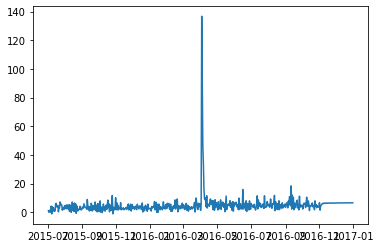

In [ ]:
plt.plot(forecast_series.index, forecast_series.values)
plt.show()

                                    Page  2015-07-01  ...  2016-12-30  2016-12-31
2  3C_zh.wikipedia.org_all-access_spider         1.0  ...         4.0        17.0

[1 rows x 551 columns]


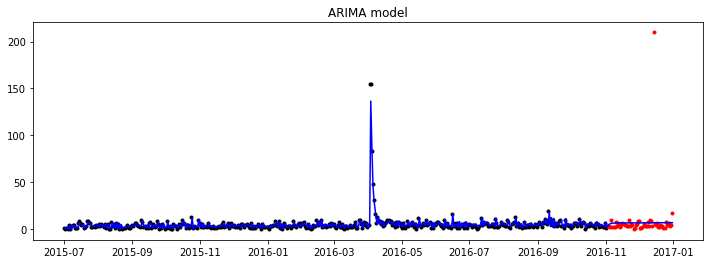

The SMAPE score is : 65.75750


In [ ]:
print(train.iloc[[2]])

df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)
lang = X_train.iloc[2, 1]
score = arima_model(df_train.copy(), df_actual.copy(), 2, 1, 2, review=True)
print("The SMAPE score is : %.5f" % score)